In [3]:
!pip install -U "tensorflow==2.8.*"
!pip install -U "tensorflow-text==2.8.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 105.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 112.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 70.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 44.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 92.6 MB/s eta 0:00:00
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.15.1
    Uninstalling tf_keras-2.15.1:
      Successfully uninstalled tf_keras-2.15.1


ImportError: /usr/local/lib/python3.10/dist-packages/tensorflow_text/core/pybinds/tflite_registrar.so: undefined symbol: _ZN4absl12lts_2021032420raw_logging_internal21internal_log_functionE

In [5]:
!pip install transformers category_encoders emot emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 27.0 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
import tensorflow_hub as hub
import keras
from keras.models import load_model
from keras import backend as K
import transformers as trfs
from transformers import BertTokenizer
import re
import emot
import emoji
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import category_encoders as ce
import matplotlib.pyplot as plt
from transformers import BertTokenizerFast, TFBertForSequenceClassification, BertConfig
import os

plt.style.use('ggplot')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
multi_encoder = LabelEncoder()
binary_encoder = LabelEncoder()
df = pd.read_excel('/content/drive/MyDrive/TextMining/Proj/deptweet_dataset.xlsx', header=0, index_col=None)
df = df[df['confidence_score'] >= 0.65]
df = df.loc[(df['label'] != 'non-depressed') | (df['confidence_score'] >= 0.8)]
df = df.loc[(df['label'] != 'mild') | (df['confidence_score'] >= 0.8)]
df = df.loc[:, ['tweet', 'label']]
df = df.dropna()


In [9]:
df['label_multi'] = df['label']
df['label_multi'] = multi_encoder.fit_transform(df['label_multi'])

multi_mappings = dict(zip( multi_encoder.transform(multi_encoder.classes_), multi_encoder.classes_))

print('Multi mapping')
print(multi_mappings)
df['label_binary'] = df['label']
df['label_binary'] = df['label_binary'].replace({'mild': 'depressed', 'moderate': 'depressed', 'severe': 'depressed'})
df['label_binary'] = binary_encoder.fit_transform(df['label_binary'])

binary_mappings = dict(zip( binary_encoder.transform(binary_encoder.classes_), binary_encoder.classes_))
print('Binary mapping')
print(binary_mappings)

Multi mapping
{0: 'mild', 1: 'moderate', 2: 'non-depressed', 3: 'severe'}
Binary mapping
{0: 'depressed', 1: 'non-depressed'}


In [ ]:
df['label'].value_counts()

label
non-depressed    23515
moderate          1798
mild              1055
severe             732
Name: count, dtype: int64

In [ ]:
df.head(10)

,tweet,label,label_multi,label_binary
1,". Yeah, I can see that. My stuff is not depres...",non-depressed,2,1
2,My focus has been scattered lately between dif...,mild,0,0
3,"I don't always think it equals depression, tho...",non-depressed,2,1
4,That show was ghastly! It had such an air of w...,non-depressed,2,1
6,Stress &amp; anxiety had me withdrawn from the...,moderate,1,0
9,Help me figure out the truth behind this. Dep...,non-depressed,2,1
10,"I love this poem, but it's the title that ring...",non-depressed,2,1
11,If you find some lively &amp; energetic person...,non-depressed,2,1
12,Lack of focus &amp; vision will lead you to de...,non-depressed,2,1
14,Its mainly focused on helping shinji out of de...,non-depressed,2,1


In [ ]:
label_counts_binary = len(df['label_binary'].value_counts())
label_counts_multi = len(df['label_multi'].value_counts())

In [ ]:
df['label_multi'].value_counts()

label_multi
2    23515
1     1798
0     1055
3      732
Name: count, dtype: int64

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

df.head()

,tweet,label,label_multi,label_binary
1,". Yeah, I can see that. My stuff is not depression tho, it's scattered focus, hard to concentrate for long or medium periods.",non-depressed,2,1
2,"My focus has been scattered lately between different games, work/lack of work, dog, depression, etc.",mild,0,0
3,"I don't always think it equals depression, though; I think it sometimes shows one's focus has become cluttered or scattered",non-depressed,2,1
4,"That show was ghastly! It had such an air of washed-out desolation, I think it taught me what depression is. Also: fish falling off cliffs",non-depressed,2,1
6,"Stress &amp; anxiety had me withdrawn from the people I most love. My dreams scattered and I was hopeless. My focus had shifted totally. Only focused on my failures &amp; how I'm valueless, amounted to nothing ... Suffered severely from depression https://t.co/wswiSsqDbC",moderate,1,0


## Preprocessing Steps

### 1. Remove URLs , Hashtags and Mentions

In [ ]:
df["tweet"].iloc[6]

"I love this poem, but it's the title that rings in my head whenever my focus is scattered by depression, anxiety, stress—the darknesses that haunt.  https://t.co/faqAL4ms6x"

In [ ]:
def remove_urls_hashtags_mentions(tweet):
    tweet = re.sub(r'https?://\S+|www\.\S+', '', tweet)
    tweet = re.sub(r'@\S+|#\S+', '', tweet)
    return tweet

# Apply remove_urls() function to tweet column
df["tweet"] = df["tweet"].astype(str).apply(lambda x: remove_urls_hashtags_mentions(x))

In [ ]:
df["tweet"].iloc[6]

"I love this poem, but it's the title that rings in my head whenever my focus is scattered by depression, anxiety, stress—the darknesses that haunt.  "

### 2. Replace emojis and emoticons with their meaning

In [ ]:
df["tweet"].iloc[13]

"Postpartum  can have several causes. As a first-time mom it can be hard to tell what the signs are. You may think that these feelings are a normal part of being a new mom. You might think that you're overtired and that in time the feelings might pass. (1/3) 👇"

In [ ]:
#Replace emojis with their meaning
def replace_emojis_with_desc(tweet):
    tweet = emoji.demojize(tweet)
    return tweet

In [ ]:
df["tweet"] = df["tweet"].astype(str).apply(lambda x: replace_emojis_with_desc(x))

In [ ]:
df["tweet"].iloc[13]

"Postpartum  can have several causes. As a first-time mom it can be hard to tell what the signs are. You may think that these feelings are a normal part of being a new mom. You might think that you're overtired and that in time the feelings might pass. (1/3) :backhand_index_pointing_down:"

In [ ]:
import emot
#create emot object
emot_obj = emot.core.emot()

# function to convert emoticons to meanings
def replace_emoticons_with_desc(tweet):
    result = emot_obj.emoticons(tweet)
    if result['flag']:
        for i, emoticon in enumerate(result['value']):
            # replace emoticon with its meaning
            emot_mean = re.split(', | or ', result['mean'][i])[0]
            tweet = tweet.replace(emoticon, emot_mean)
    return tweet

# apply function to dataframe
df['tweet'] = df['tweet'].apply(replace_emoticons_with_desc)

In [ ]:
df["tweet"].iloc[13]

"Postpartum  can have several causes. As a first-time mom it can be hard to tell what the signs are. You may think that these feelings are a normal part of being a new mom. You might think that you're overtired and that in time the feelings might pass. (1/3) Tongue sticking outackhand_index_pointing_down:"

### Balancing Dataset.

In [ ]:
df['label'].value_counts()

label
non-depressed    23515
moderate          1798
mild              1055
severe             732
Name: count, dtype: int64

In [ ]:
df_non_balanced = df
df = df.drop(df[df['label'] == 'non-depressed'].sample(n=21000).index)

In [ ]:
df_non_balanced['label'].value_counts()

label
non-depressed    23515
moderate          1798
mild              1055
severe             732
Name: count, dtype: int64

In [ ]:
df['label'].value_counts()

label
non-depressed    2515
moderate         1798
mild             1055
severe            732
Name: count, dtype: int64

In [ ]:
df_binary = df[['tweet','label_binary']]

In [ ]:
df_binary.head()

,tweet,label_binary
2,"My focus has been scattered lately between different games, work/lack of work, dog, depression, etc.",0
6,"Stress &amp; anxiety had me withdrawn from the people I most love. My dreams scattered and I was hopeless. My focus had shifted totally. Only focused on my failures &amp; how I'm valueless, amounted to nothing ... Suffered severely from depression",0
11,"If you find some lively &amp; energetic person suddenly converting in gloomy,sad,depressed,low spirited.just observe them.He or she might be suffering from depression.Try to understand them,talk to them &amp; help them in taking medical help and letting them come out from this condition.",1
14,Its mainly focused on helping shinji out of depression The player will be able to take shinji on dates to multiple places You can find the outfits scattered around and meet with people I am still writing most of the plot I plan on making some cooking on it too,1
15,Omg I so did not want to workout today. I was overtired and I just wanted to sleep! I noticed how I was slowly slipping into depression and feeling overwhelmed with all the stuff going on everywhere that I've been…,0


In [ ]:
os.environ["TFHUB_MODEL_LOAD_FORMAT"] = "COMPRESSED"
bert_preprocess = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.load('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1')
#bert_encoder = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

## Creating Binary Classification Model

In [ ]:
MAX_SEQUENCE_LENGTH = 64

# Standard BERT model with lowercase chars only:
PRETRAINED_MODEL_NAME = 'bert-base-uncased'

# Batch size for fitting:
BATCH_SIZE = 16

# Number of epochs:
EPOCHS=3

In [ ]:
def get_sentence_embedding(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embedding([
    'I like cake',
    "I am actually in quite a good mood today",
    "NLP is sexy"
])

<tf.Tensor: shape=(3, 512), dtype=float32, numpy=
array([[ 0.99229777, -0.01513666,  0.05493826, ..., -0.05468187,
        -0.5488707 , -0.38407406],
       [-0.21741459,  0.5586059 , -0.15250148, ...,  0.15710323,
        -0.6344824 , -0.21221742],
       [ 0.99822724,  0.4057874 , -0.09452087, ..., -0.15771917,
        -0.05090043, -0.28836712]], dtype=float32)>

In [ ]:
bert_preprocess_model = hub.KerasLayer(bert_preprocess)
bert_model = hub.KerasLayer(bert_encoder)

In [ ]:
def create_model(max_sequence, model_name, num_labels):
    bert_model = trfs.TFBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    # This is the input for the tokens themselves(words from the dataset after encoding):
    input_ids = tf.keras.layers.Input(shape=(max_sequence,), dtype=tf.int32, name='input_ids')

    # attention_mask - is a binary mask which tells BERT which tokens to attend and which not to attend.
    # Encoder will add the 0 tokens to the some sequence which smaller than MAX_SEQUENCE_LENGTH,
    # and attention_mask, in this case, tells BERT where is the token from the original data and where is 0 pad token:
    attention_mask = tf.keras.layers.Input((max_sequence,), dtype=tf.int32, name='attention_mask')

    # Use previous inputs as BERT inputs:
    output = bert_model([input_ids, attention_mask])[0]

    # We can also add dropout as regularization technique:
    output = tf.keras.layers.Dropout(rate=0.15)(output)

    # Provide number of classes to the final layer:
    output = tf.keras.layers.Dense(1, activation='sigmoid')(output)

    # Final model:
    model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)
    return model

In [ ]:
model = create_model(MAX_SEQUENCE_LENGTH, PRETRAINED_MODEL_NAME, df_binary.label_binary.nunique())

opt = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
tokenizer = trfs.BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

In [ ]:
def batch_encode(X):
    return tokenizer.batch_encode_plus(
    X,
    max_length=MAX_SEQUENCE_LENGTH, # set the length of the sequences
    add_special_tokens=True, # add [CLS] and [SEP] tokens
    return_attention_mask=True,
    return_token_type_ids=False, # not needed for this type of ML task
    pad_to_max_length=True, # add 0 pad tokens to the sequences less than max_length
    return_tensors='tf'
)

In [ ]:
df_binary.head()

,tweet,label_binary
2,"My focus has been scattered lately between different games, work/lack of work, dog, depression, etc.",0
6,"Stress &amp; anxiety had me withdrawn from the people I most love. My dreams scattered and I was hopeless. My focus had shifted totally. Only focused on my failures &amp; how I'm valueless, amounted to nothing ... Suffered severely from depression",0
9,Help me figure out the truth behind this. Depression hit you harder ... 1- If you are originally a happy go lucky person Than 2- If you are originally a low spirited person Like for 1 Retweet for 2,1
14,Its mainly focused on helping shinji out of depression The player will be able to take shinji on dates to multiple places You can find the outfits scattered around and meet with people I am still writing most of the plot I plan on making some cooking on it too,1
15,Omg I so did not want to workout today. I was overtired and I just wanted to sleep! I noticed how I was slowly slipping into depression and feeling overwhelmed with all the stuff going on everywhere that I've been…,0


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_binary.tweet.values, df_binary.label_binary.values, test_size=0.2)


In [ ]:
X_train = batch_encode(X_train )
X_val = batch_encode(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Training the Binary Classification Model

In [ ]:
history = model.fit(
    x=X_train.values(),
    y=y_train,
    validation_data=(X_val.values(), y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/3
305/305 [==============================] - 73s 108ms/step - loss: 0.3476 - accuracy: 0.8525 - val_loss: 0.2751 - val_accuracy: 0.8836
Epoch 2/3
305/305 [==============================] - 17s 57ms/step - loss: 0.1696 - accuracy: 0.9365 - val_loss: 0.2710 - val_accuracy: 0.9025
Epoch 3/3
305/305 [==============================] - 16s 52ms/step - loss: 0.0818 - accuracy: 0.9711 - val_loss: 0.4471 - val_accuracy: 0.8844


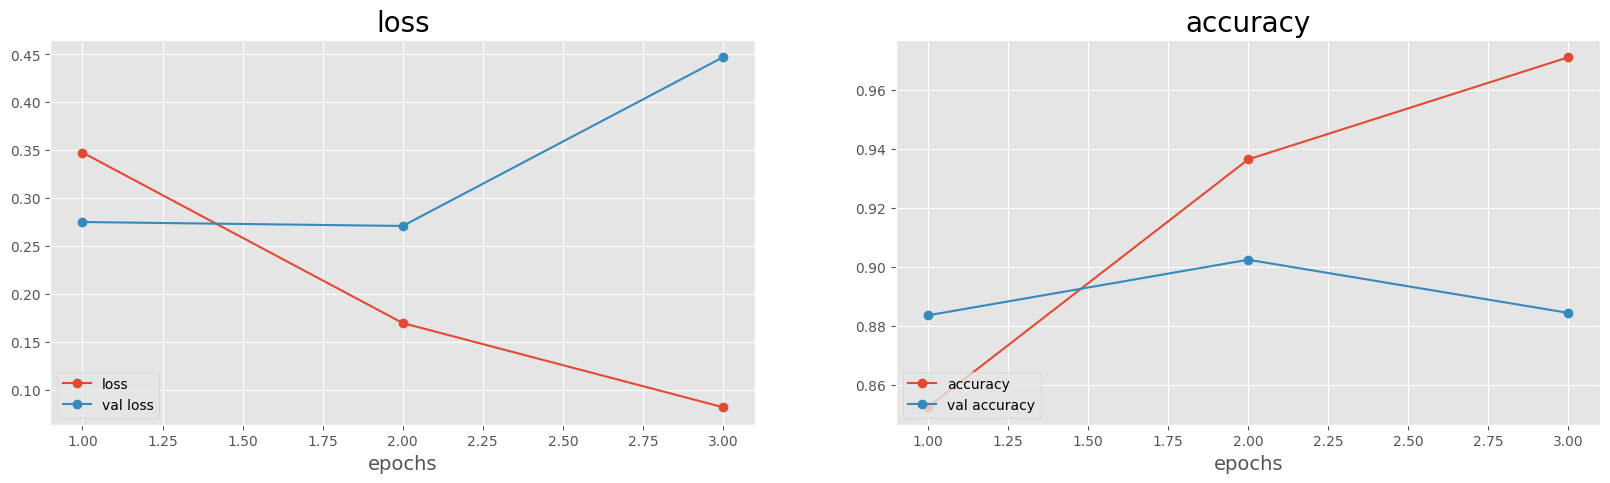

In [ ]:
# Number of epochs:
EPOCHS=len(history.history['loss'])
x = list(range(1, EPOCHS+1))
metric_list = list(history.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(20, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, history.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, history.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

In [ ]:
binary_mappings

{0: 'depressed', 1: 'non-depressed'}

# Binary Encoding Playground!!!!

After training the data use this to play with the data to see what the model does. Unfortunately I did not get the loading model part to work so you would have to train the data yourself.

In [ ]:
tokenizer = trfs.BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
      input_text,
      max_length=MAX_SEQUENCE_LENGTH, # set the length of the sequences
      add_special_tokens=True, # add [CLS] and [SEP] tokens
      return_attention_mask=True,
      truncation=True,
      return_token_type_ids=False, # not needed for this type of ML task
      padding='max_length', # add 0 pad tokens to the sequences less than max_length
      return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data, encoding_mapping):
    probs = model.predict(processed_data)[0]
    print(encoding_mapping)
    return encoding_mapping[round(probs[0])]

In [ ]:
input_text = input('Enter status here: ')
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(model, processed_data=processed_data, encoding_mapping= binary_mappings)
print(f"Predicted Sentiment: {result}")

Enter status here: I like cake
1/1 [==============================] - 3s 3s/step
{0: 'depressed', 1: 'non-depressed'}
Predicted Sentiment: non-depressed


# Multi Category

In [ ]:
df_multi = df[['tweet','label_multi']]
df_multi_non_balanced = df_non_balanced[['tweet','label_multi']]

### Create Multiple Categorizer Model

In [ ]:
MAX_SEQUENCE_LENGTH = 64

# Standard BERT model with lowercase chars only:
PRETRAINED_MODEL_NAME = 'bert-base-uncased'

# Batch size for fitting:
BATCH_SIZE = 16

# Number of epochs:
EPOCHS=3

In [ ]:
def create_multi_model(max_sequence, model_name, num_labels):
    bert_model = trfs.TFBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    # This is the input for the tokens themselves(words from the dataset after encoding):
    input_ids = tf.keras.layers.Input(shape=(max_sequence,), dtype=tf.int32, name='input_ids')

    # attention_mask - is a binary mask which tells BERT which tokens to attend and which not to attend.
    # Encoder will add the 0 tokens to the some sequence which smaller than MAX_SEQUENCE_LENGTH,
    # and attention_mask, in this case, tells BERT where is the token from the original data and where is 0 pad token:
    attention_mask = tf.keras.layers.Input((max_sequence,), dtype=tf.int32, name='attention_mask')

    # Use previous inputs as BERT inputs:
    output = bert_model([input_ids, attention_mask])[0]

    # We can also add dropout as regularization technique:
    output = tf.keras.layers.Dropout(rate=0.15)(output)

    # Provide number of classes to the final layer:
    output = tf.keras.layers.Dense(4, activation='softmax')(output)

    # Final model:
    model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)
    return model

In [ ]:
df_multi['label_multi'].value_counts()

label_multi
2    2515
1    1798
0    1055
3     732
Name: count, dtype: int64

In [ ]:
print('Multi mapping')
print(multi_mappings)

Multi mapping
{0: 'mild', 1: 'moderate', 2: 'non-depressed', 3: 'severe'}


In [ ]:
multi_model = create_multi_model(MAX_SEQUENCE_LENGTH, PRETRAINED_MODEL_NAME, df_multi.label_multi.nunique())
opt = tf.keras.optimizers.Adam(learning_rate=3e-5)
multi_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
multi_tokenizer = trfs.BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def multi_batch_encode(X, multi_tokenizer):
    return multi_tokenizer.batch_encode_plus(
    X,
    max_length=MAX_SEQUENCE_LENGTH, # set the length of the sequences
    add_special_tokens=True, # add [CLS] and [SEP] tokens
    return_attention_mask=True,
    return_token_type_ids=False, # not needed for this type of ML task
    pad_to_max_length=True, # add 0 pad tokens to the sequences less than max_length
    return_tensors='tf'
)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_multi.tweet.values, df_multi.label_multi.values, test_size=0.2)
X_train_non_balanced, X_val_non_balanced, y_train_non_balanced, y_val_non_balanced = train_test_split(df_multi_non_balanced.tweet.values, df_multi_non_balanced.label_multi.values, test_size=0.2)

In [ ]:
X_train = multi_batch_encode(X_train,multi_tokenizer)
X_val = multi_batch_encode(X_val, multi_tokenizer)

X_train_non_balanced = multi_batch_encode(X_train_non_balanced,multi_tokenizer)
X_val_non_balanced = multi_batch_encode(X_val_non_balanced, multi_tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
X_val

{'input_ids': <tf.Tensor: shape=(1220, 64), dtype=int32, numpy=
array([[  101,  2026,  2227, ...,     0,     0,     0],
       [  101,  2108,  3294, ...,     0,     0,     0],
       [  101,  1045,  5223, ...,     0,     0,     0],
       ...,
       [  101, 21244,  1013, ...,     0,     0,     0],
       [  101,  2053,  3043, ...,  4959,   102,     0],
       [  101,  1045,  2074, ..., 27152,  4647,   102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1220, 64), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>}

### Train Multiple Categorizer Model

## Balanced

In [ ]:
history = multi_model.fit(
    x=X_train.values(),
    y=y_train,
    validation_data=(X_val.values(), y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/3
305/305 [==============================] - 483s 2s/step - loss: 1.0539 - accuracy: 0.5551 - val_loss: 0.8631 - val_accuracy: 0.6770
Epoch 2/3
305/305 [==============================] - 471s 2s/step - loss: 0.8134 - accuracy: 0.6943 - val_loss: 0.7926 - val_accuracy: 0.7123
Epoch 3/3
305/305 [==============================] - 470s 2s/step - loss: 0.6892 - accuracy: 0.7605 - val_loss: 0.8499 - val_accuracy: 0.7221


In [ ]:
multi_model.save('balanced_multi_model.h5')

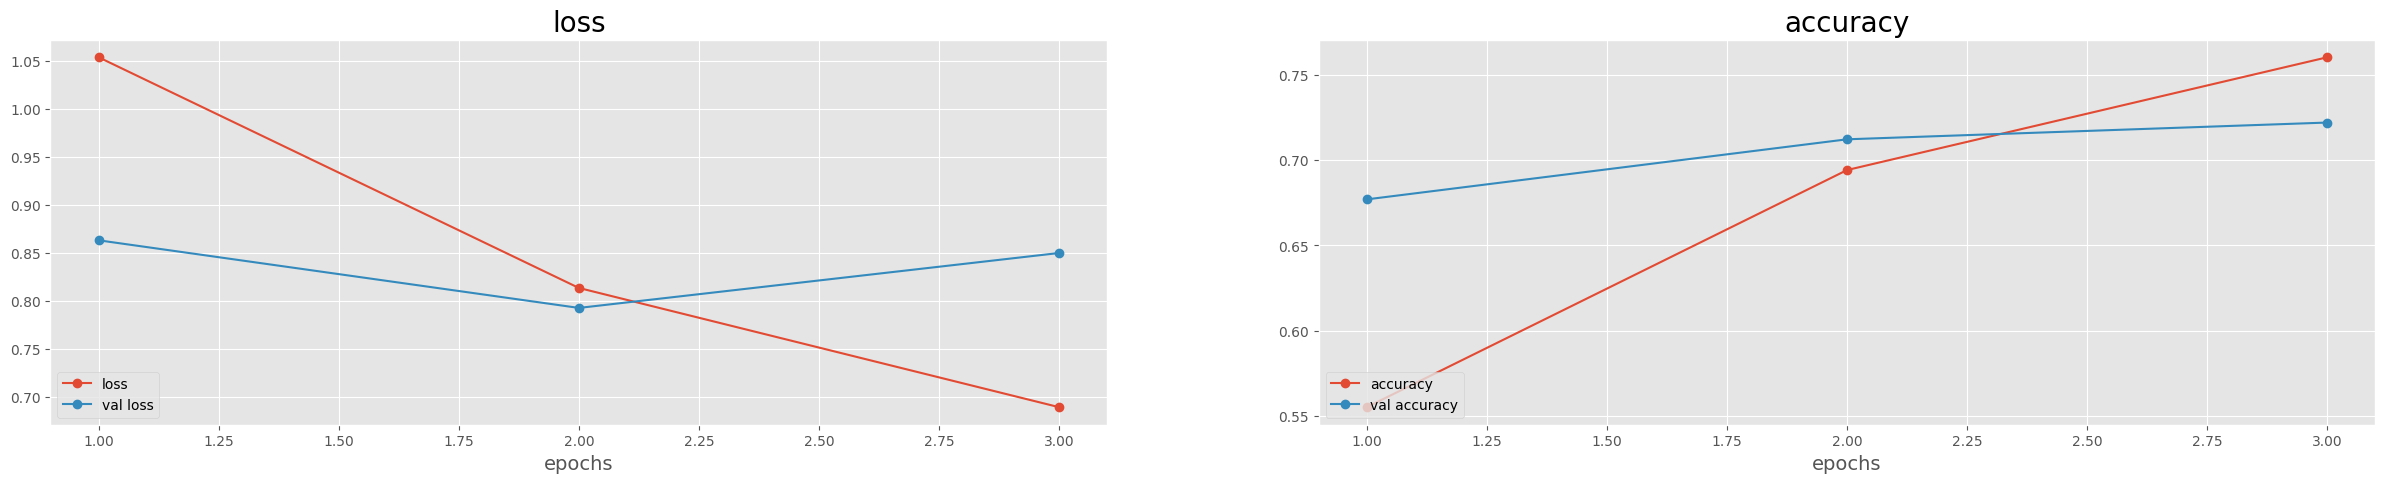

In [ ]:
# If Number of epochs go up in code and find where I declared it:
EPOCHS = len(history.history['loss'])
x = list(range(1, EPOCHS+1))
metric_list = list(history.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, history.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, history.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

In [ ]:
multi_mappings

{0: 'mild', 1: 'moderate', 2: 'non-depressed', 3: 'severe'}

In [ ]:
y_pred = multi_model.predict(X_val.values())
y_pred = np.argmax(y_pred, axis=1)

conf_mat = confusion_matrix(y_val, y_pred, labels=[2,0,1,3])

In [ ]:
conf_mat = conf_mat / conf_mat.astype(float).sum(axis=1)[:, np.newaxis]

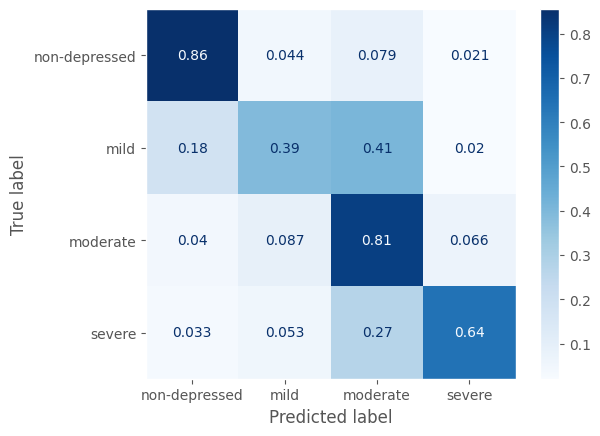

In [ ]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = [ 'non-depressed','mild', 'moderate', 'severe'])
cm_display.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

# Non Balanced

In [ ]:
multi_model_non_balanced = create_multi_model(MAX_SEQUENCE_LENGTH, PRETRAINED_MODEL_NAME, df_multi_non_balanced.label_multi.nunique())
opt = tf.keras.optimizers.Adam(learning_rate=3e-5)
multi_model_non_balanced.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
history_non_balanced = multi_model_non_balanced.fit(
    x=X_train_non_balanced.values(),
    y=y_train_non_balanced,
    validation_data=(X_val_non_balanced.values(), y_val_non_balanced),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/3
  55/1355 [>.............................] - ETA: 59:49 - loss: 0.7002 - accuracy: 0.8080

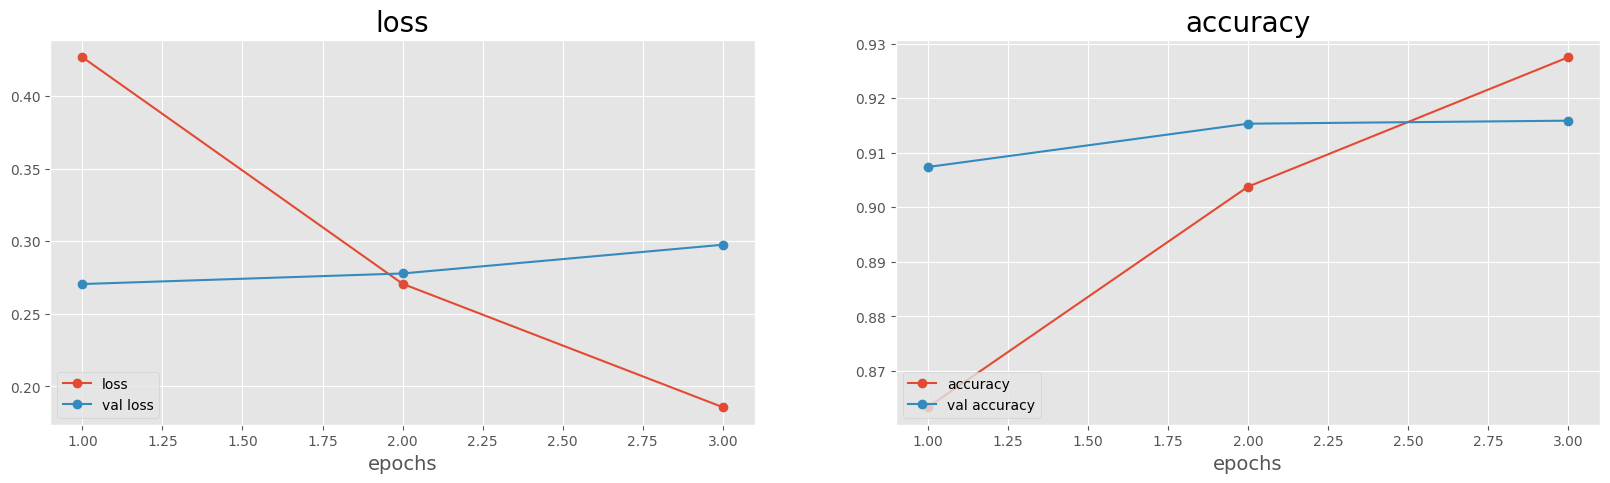

In [ ]:
# If Number of epochs go up in code and find where I declared it:
EPOCHS = len(history_non_balanced.history['loss'])
x = list(range(1, EPOCHS+1))
metric_list = list(history.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

for i in range(0, 2):
  ax[i].plot(x, history_non_balanced.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, history_non_balanced.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

In [ ]:
y_pred = multi_model_non_balanced.predict(X_val_non_balanced.values())
y_pred = np.argmax(y_pred, axis=1)

170/170 [==============================] - 8s 27ms/step


<ipython-input-112-a8c6dd7cf55f>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  conf_mat = conf_mat / conf_mat.astype(np.float).sum(axis=1)[:, np.newaxis]


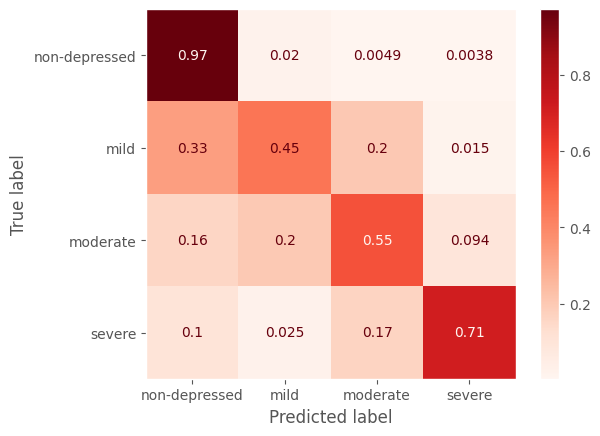

In [ ]:
conf_mat = confusion_matrix(y_val_non_balanced, y_pred, labels=[2,0,1,3])
conf_mat = conf_mat / conf_mat.astype(np.float).sum(axis=1)[:, np.newaxis]
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = [ 'non-depressed','mild', 'moderate', 'severe'])
cm_display.plot(cmap=plt.cm.Reds)
plt.grid(False)
plt.show()

# Multi-Sentiment model Playground!

In [ ]:
multi_model = tf.keras.models.load_model('balanced_multi_model.h5', custom_objects={"TFBertForSequenceClassification": trfs.TFBertForSequenceClassification})

In [ ]:
PRETRAINED_MODEL_NAME = 'bert-base-uncased'

tokenizer = trfs.BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
      input_text,
      max_length=MAX_SEQUENCE_LENGTH, # set the length of the sequences
      add_special_tokens=True, # add [CLS] and [SEP] tokens
      return_attention_mask=True,
      truncation=True,
      return_token_type_ids=False, # not needed for this type of ML task
      padding='max_length', # add 0 pad tokens to the sequences less than max_length
      return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def make_prediction(model, processed_data, encoding_mapping):
    probs = model.predict(processed_data)
    print(np.around(NormalizeData(probs[0]),decimals=3))
    print(encoding_mapping)
    return encoding_mapping[np.argmax(probs[0])]

In [ ]:
input_text = input('Enter status here: ')
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(multi_model, processed_data=processed_data, encoding_mapping=multi_mappings)
print(f"Predicted Sentiment: {result}")

Enter status here: I'm so sad. I cant sleep at all and want to kill myself everyday.
[0.322 0.021 0.    1.   ]
{0: 'mild', 1: 'moderate', 2: 'non-depressed', 3: 'severe'}
Predicted Sentiment: severe


In [ ]:
input_text = input('Enter status here: ')
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(multi_model, processed_data=processed_data, encoding_mapping=multi_mappings)
print(f"Predicted Sentiment: {result}")

# Predicting different types of mental health issues.

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/TextMining/Proj/bert_preprocessed_train.csv')
df_val = pd.read_csv('/content/drive/MyDrive/TextMining/Proj/bert_preprocessed_val.csv')
df_test = pd.read_csv('/content/drive/MyDrive/TextMining/Proj/bert_preprocessed_test.csv')

In [ ]:
df_train.head()

,ID,title,post,class_name,class_id,Text,Length,Word_Count,Tokens
0,691324c4-5c30-44e0-b9e4-45b4f0715e21,a question about the third conditional.,i was making questions for my students and i r...,none,5,a question about the third conditional. i was ...,457,79,"['a', 'question', 'about', 'the', 'conditional..."
1,d4295391-9ca5-4398-b7c8-687e4a984ef1,the epitome of my life,i've recently requested testing accommodations...,adhd,0,the epitome of my life i've recently requested...,735,143,"['the', 'epitome', 'of', 'my', 'life', 'i', 'h..."
2,58937fa5-3c2c-426b-8255-5a140fbab675,what are your favourites offbeat destinations ...,**cambodia** * koh rong: amazing beaches and a...,none,5,what are your favourites offbeat destinations ...,3085,460,"['what', 'be', 'your', 'favourite', 'offbeat',..."
3,7daf364c-3b33-4cbe-be37-a214edf9a73e,synesthesia survey (what colour is each month ...,synesthesia. what is synesthesia? according to...,none,5,synesthesia survey (what colour is each month ...,1164,195,"['synesthesia', 'survey', 'what', 'colour', 'b..."
4,22518271-4bb4-4caf-b683-7305da519288,"science ama series: i’m phil baran, and i’m he...",i’m phil baran and i teach organic chemistry a...,none,5,"science ama series: i’m phil baran, and i’m he...",2048,338,"['science', 'ama', 'series', 'i', 'm', 'phil',..."


In [ ]:
df_val.head()

,ID,title,post,class_name,class_id,Text,Tokens
0,34db02f0-82ed-43e9-ac8b-65db8ba55a95,do others feel like they have a warped sense o...,i have read others talking about how add/adhd ...,adhd,0,do others feel like they have a warped sense o...,"['do', 'other', 'feel', 'like', 'they', 'have'..."
1,f515fc3a-0f62-4203-bfc8-53a8252a8fc1,do you ever feel like one small failure can de...,"last night, i thought i had enough time to fin...",adhd,0,do you ever feel like one small failure can de...,"['do', 'you', 'ever', 'feel', 'like', 'small',..."
2,93ed44ff-20b8-4bc2-b71b-6c7a39fa4775,so you've heard about getting a song in your h...,... random words in your head that won't go aw...,adhd,0,so you've heard about getting a song in your h...,"['so', 'you', 've', 'hear', 'about', 'get', 'a..."
3,e9ec2f5b-f709-40c4-b4f2-202ebbe5bc87,anyone here have listening comprehension probl...,"it's like i can hear what people say, but ofte...",adhd,0,anyone here have listening comprehension probl...,"['anyone', 'here', 'have', 'listen', 'comprehe..."
4,2e6f28e3-acbe-44ac-82f0-a980aa07a464,i finally found a way to wake my ass up in the...,not sure if i'm alone in struggling to get out...,adhd,0,i finally found a way to wake my ass up in the...,"['i', 'finally', 'find', 'a', 'way', 'to', 'wa..."


In [ ]:
df_test.head()

,ID,title,post,class_name,class_id,Text,Tokens
0,b07b978c-7760-4932-85cb-5797b5e74168,"basic needs for neurotypicals : food, clothing...",most people able to be productive and function...,adhd,0,"basic needs for neurotypicals : food, clothing...","['basic', 'need', 'for', 'neurotypical', 'food..."
1,b2868fd2-e885-400e-b780-446c9581b1f1,"""you're just an iphone in an android world.: d...",i'm 23f and recently quit my job as a features...,adhd,0,"""you're just an iphone in an android world.: d...","['you', 're', 'just', 'an', 'iphone', 'in', 'a..."
2,3191b3b1-d355-41b6-9588-caeb3e169c9b,"""what kind of music do you listen to?"" no answer",i just got finished with an interview and as t...,adhd,0,"""what kind of music do you listen to?"" no answ...","['what', 'kind', 'of', 'music', 'do', 'you', '..."
3,a3d60895-ef7c-4b57-b5be-632c9fd62150,couldn’t help crying while reading a post that...,off course i’ve forgotten what i exactly read....,adhd,0,couldn’t help crying while reading a post that...,"['could', 'not', 'help', 'cry', 'while', 'read..."
4,66fae18e-e744-495f-b7a0-b985543f5052,shout-out to all the parents with adhd childre...,"i have six siblings, and at least 4 of us have...",adhd,0,shout-out to all the parents with adhd childre...,"['shoutout', 'to', 'all', 'the', 'parent', 'wi..."


In [ ]:
df_test['title_post'] = df_test['title'] +"\n "+ df_test["post"]
df_train['title_post'] = df_train['title'] +"\n "+ df_train["post"]
df_val['title_post'] = df_val['title'] +"\n "+ df_val["post"]

In [ ]:
df_test.head()

,ID,title,post,class_name,class_id,Text,Tokens,title_post
0,b07b978c-7760-4932-85cb-5797b5e74168,"basic needs for neurotypicals : food, clothing...",most people able to be productive and function...,adhd,0,"basic needs for neurotypicals : food, clothing...","['basic', 'need', 'for', 'neurotypical', 'food...","basic needs for neurotypicals : food, clothing..."
1,b2868fd2-e885-400e-b780-446c9581b1f1,"""you're just an iphone in an android world.: d...",i'm 23f and recently quit my job as a features...,adhd,0,"""you're just an iphone in an android world.: d...","['you', 're', 'just', 'an', 'iphone', 'in', 'a...","""you're just an iphone in an android world.: d..."
2,3191b3b1-d355-41b6-9588-caeb3e169c9b,"""what kind of music do you listen to?"" no answer",i just got finished with an interview and as t...,adhd,0,"""what kind of music do you listen to?"" no answ...","['what', 'kind', 'of', 'music', 'do', 'you', '...","""what kind of music do you listen to?"" no answ..."
3,a3d60895-ef7c-4b57-b5be-632c9fd62150,couldn’t help crying while reading a post that...,off course i’ve forgotten what i exactly read....,adhd,0,couldn’t help crying while reading a post that...,"['could', 'not', 'help', 'cry', 'while', 'read...",couldn’t help crying while reading a post that...
4,66fae18e-e744-495f-b7a0-b985543f5052,shout-out to all the parents with adhd childre...,"i have six siblings, and at least 4 of us have...",adhd,0,shout-out to all the parents with adhd childre...,"['shoutout', 'to', 'all', 'the', 'parent', 'wi...",shout-out to all the parents with adhd childre...


In [ ]:
df_train['title_post'] = df_train['title'] +"\n "+ df_train["post"]
df_val['title_post'] = df_val['title'] +"\n "+ df_val["post"]
df_test['title_post'] = df_test['title'] +"\n "+ df_test["post"]

In [ ]:
df_train_multi = df_train[['title_post','class_id']]
df_val_multi = df_val[['title_post','class_id']]
df_test_multi = df_test[['title_post','class_id']]

In [ ]:
df_train_multi.head()

,title_post,class_id
0,"a question about the third conditional.\n i was making questions for my students and i ran into a little tricky grammar. which is correct (focusing on the latter part of the sentence): &amp;#x200b; * if you had traveled to australia yesterday, what wouldn't you have done while you had been there? * if you had traveled to australia yesterday, what wouldn't you have done while you were there? &amp;#x200b; the second \*feels\* right, but i want to make sure.",5
1,"the epitome of my life\n i've recently requested testing accommodations at my university and was given letters to personally give to my professors. so i gave the first one i saw his and he was very nice about it. the next day i brought the next professor his (he probably thinks i'm a nut i'm always screwing stuff up in this class) and he was also very nice about it. shortly after leaving i receive an email from him: ""actually you gave me a form meant for another class and instructor. i can get it back to you on tuesday should you need it."" i had 2 papers to keep track of and distribute, i really thought i paid attention to which letter was which. i can't even help people help me what is this. i both cried and laughed my ass off",0
2,"what are your favourites offbeat destinations of asia? this is my list.\n **cambodia** * koh rong: amazing beaches and a very serene romantic island * kratie: very beautiful and small town with amazing sunsets **china** * guilin: nature's paradise. rivers, lakes and the karst mountains * chongqing: caves, mountains, natural limestone bridges * zhangjiajie: gorges and thousands of out-of-the-world pillar like formations **india** * dalhousie: beautiful hill station and friendly people * gokarna: amazing beaches and laid back culture **indonesia** * yogyakarta: regarded as the soul of indonesia with its traditional arts, intellectual and cultural heritage. * raja ampat islands: islands are home to great white sandy beaches, hidden lagoons, spooky caves, weird mushroom shaped islets, fringing coral reefs and emerald waters. **japan** * aizuwakamatsu: samurai culture. history. unique cuisine * nikko: very beautiful mountain town with great architecture **jordan** * jerash: greco-roman ruins of gerasa that are the largest and most diverse ruins in jordan. * wadi rum valley: (not offbeat, but a trip to jordan is incomplete without it) can enjoy camping in the desert and camel riding. **kazakhstan** * shymbulak: amazing ski resort and beautiful mountains * karaganda: food capital and pretty 20th century buildings * almaty region: ile alatau national park and kolsai lake (unbelievable place) **kyrgyzstan** * karakol: great food. hospitable people who will invite you for family dinner * jyrgalan: secret destination. great for trekking and amazing night sky for star-gazing **laos** * vang vieng: backpacker friendly with nice bars, beautiful town and activities like caves, kayaking * nong khiaw: great adventure destination. rock climbing. stay with nature **malaysia** * ipoh: very beautiful city to enjoy culture * tioman island: amazing beaches, corals, dive sites **myanmar** * mergui: very beautiful 800+ islands and is one of the least visited places on the earth. * chaung tha: very beautiful sunsets **nepal** * mustang: great for trekking and adventure activities * namche bazaar: beautiful tiny village to witness the lifestyle of the sherpa people and their traditions **philippines** * vigan: romantic city with cobblestone streets, rich history and delicious food. * sagada: adveture destination. beautiful caves, hanging coffins and serene mountains **russia** * sochi: very beautiful beaches and pretty architecture * karelia: nature's paradise with beautiful lakes. enjoy snowmobiling , dog-sledding, boat trips and hiking * yakutsk: one of the coldest places on earth. experience permafrost. **south korea** * jeju: beaches, resorts and its volcanic landscape of craters and cave * boseong: green tea fields, buddhist temples and

In [ ]:
X_train = df_train_multi['title_post'].to_numpy()
X_val = df_val_multi['title_post'].to_numpy()
X_test = df_test_multi['title_post'].to_numpy()

y_train = df_train_multi['class_id'].to_numpy()
y_val = df_val_multi['class_id'].to_numpy()
y_test = df_test_multi['class_id'].to_numpy()

In [ ]:
y_train

array([5, 0, 5, ..., 5, 2, 5])

In [ ]:
MAX_SEQUENCE_LENGTH = 1500

# Standard BERT model with lowercase chars only:
PRETRAINED_MODEL_NAME = 'bert-base-uncased'

# Batch size for fitting:
BATCH_SIZE = 2

# Number of epochs:
EPOCHS=3

In [ ]:
def create_multi_model(max_sequence, model_name, num_labels):
    bert_model = trfs.TFBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    # This is the input for the tokens themselves(words from the dataset after encoding):
    input_ids = tf.keras.layers.Input(shape=(max_sequence,), dtype=tf.int32, name='input_ids')

    # attention_mask - is a binary mask which tells BERT which tokens to attend and which not to attend.
    # Encoder will add the 0 tokens to the some sequence which smaller than MAX_SEQUENCE_LENGTH,
    # and attention_mask, in this case, tells BERT where is the token from the original data and where is 0 pad token:
    attention_mask = tf.keras.layers.Input((max_sequence,), dtype=tf.int32, name='attention_mask')

    # Use previous inputs as BERT inputs:
    output = bert_model([input_ids, attention_mask])[0]

    # We can also add dropout as regularization technique:
    output = tf.keras.layers.Dropout(rate=0.15)(output)

    # Provide number of classes to the final layer:
    output = tf.keras.layers.Dense(num_labels, activation='softmax')(output)

    # Final model:
    model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)
    return model

In [ ]:
multi_model_mental_health = create_multi_model(MAX_SEQUENCE_LENGTH, PRETRAINED_MODEL_NAME, df_train_multi.class_id.nunique())

opt = tf.keras.optimizers.Adam(learning_rate=3e-5)
multi_model_mental_health.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
multi_tokenizer = trfs.BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

In [ ]:
def multi_batch_encode(X, multi_tokenizer):
    return multi_tokenizer.batch_encode_plus(
    X,
    max_length=MAX_SEQUENCE_LENGTH, # set the length of the sequences
    add_special_tokens=True, # add [CLS] and [SEP] tokens
    return_attention_mask=True,
    truncation=True,
    return_token_type_ids=False, # not needed for this type of ML task
    pad_to_max_length=True, # add 0 pad tokens to the sequences less than max_length
    return_tensors='tf'
)

In [ ]:
X_train = multi_batch_encode(X_train,multi_tokenizer)
X_val = multi_batch_encode(X_val, multi_tokenizer)
X_test = multi_batch_encode(X_test, multi_tokenizer)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
print(tf.shape(X_train))

tf.Tensor([2], shape=(1,), dtype=int32)


In [ ]:
history_mental_health = multi_model_mental_health.fit(
    x=X_train.values(),
    y=y_train,
    validation_data=(X_val.values(), y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/3
6864/6864 [==============================] - 1210s 169ms/step - loss: 0.8550 - accuracy: 0.7104 - val_loss: 0.5880 - val_accuracy: 0.8078
Epoch 2/3
6864/6864 [==============================] - 1074s 157ms/step - loss: 0.5697 - accuracy: 0.8229 - val_loss: 0.5703 - val_accuracy: 0.8280
Epoch 3/3
6864/6864 [==============================] - 1070s 156ms/step - loss: 0.4420 - accuracy: 0.8672 - val_loss: 0.4967 - val_accuracy: 0.8468


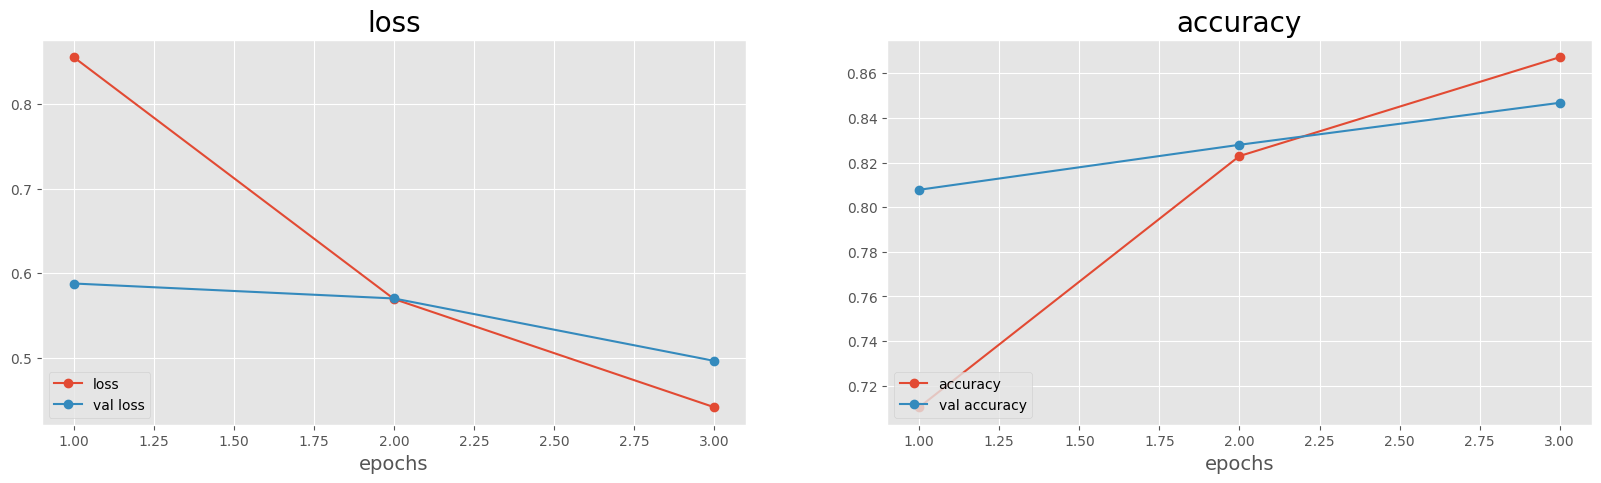

In [ ]:
# Number of epochs:
EPOCHS = len(history_mental_health.history['loss'])
x = list(range(1, EPOCHS+1))
metric_list = list(history_mental_health.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(20, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, history_mental_health.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, history_mental_health.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

In [ ]:
y_pred = multi_model_mental_health.predict(X_val.values())
y_pred = np.argmax(y_pred, axis=1)

conf_mat = confusion_matrix(y_val, y_pred)


In [ ]:
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')

In [ ]:
print("Validation Data final Stats:")
print("Accuracy", accuracy)
print("F1", f1)

Validation Data final Stats:
Accuracy 0.8467741935483871
F1 0.8477394000870422


In [ ]:
y_pred_test = multi_model_mental_health.predict(X_test.values())
y_pred_test = np.argmax(y_pred_test, axis=1)

accuracy_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test, average='weighted')

print("Test Data final Stats:")
print("Accuracy", accuracy_test)
print("F1", f1_test)

47/47 [==============================] - 31s 648ms/step
Test Data final Stats:
Accuracy 0.8434139784946236
F1 0.8436145570244402


In [ ]:
conf_mat = conf_mat / conf_mat.astype(np.float).sum(axis=1)[:, np.newaxis]

<ipython-input-149-d498ee396d63>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  conf_mat = conf_mat / conf_mat.astype(np.float).sum(axis=1)[:, np.newaxis]


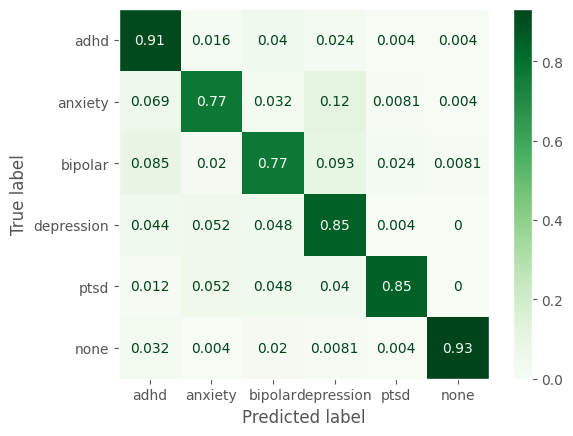

In [ ]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = ['adhd', 'anxiety', 'bipolar', 'depression','ptsd','none'])
cm_display.plot(cmap=plt.cm.Greens)
plt.grid(False)
plt.show()